# ELE510 Image Processing with robot vision: LAB, Exercise 6, Image features detection.

### **Purpose:** *To learn about the edges and corners features detection, and their descriptors.*

The theory for this exercise can be found in chapter 7 of the text book [1] and in appendix C in the compendium [2]. See also the following documentations for help:
- [OpenCV](https://opencv.org/opencv-python-free-course/)
- [numpy](https://numpy.org/doc/stable/)
- [matplotlib](https://matplotlib.org/stable/contents.html)
- [scipy](https://docs.scipy.org/doc/)


**IMPORTANT:** Read the text carefully before starting the work. In
many cases it is necessary to do some preparations before you start the work
on the computer. Read necessary theory and answer the theoretical part
first. The theoretical and experimental part should be solved individually.
The notebook must be approved by the lecturer or his assistant.

**Approval:**
<div class="alert alert-block alert-success">
The current notebook should be submitted on CANVAS as a single pdf file. 
</div>

<div class="alert alert-block alert-info">
    To export the notebook in a pdf format, goes to File -> Download as -> PDF via LaTeX (.pdf).
</div>

**Note regarding the notebook**: The theoretical questions can be answered directly on the notebook using a *Markdown* cell and LaTex commands (if relevant). In alternative, you can attach a scan (or an image) of the answer directly in the cell.

Possible ways to insert an image in the markdown cell:

`![image name]("image_path")`

`<img src="image_path" alt="Alt text" title="Title text" />`


**Under you will find parts of the solution that is already programmed.**

<div class="alert alert-block alert-info">
    <p>You have to fill out code everywhere it is indicated with `...`</p>
    <p>The code section under `######## a)` is answering subproblem a) etc.</p>
</div>

## Problem 1

**Intensity edges** are pixels in the image where the intensity (or graylevel) function changes rapidly.

The **Canny edge detector** is a classic algorithm for detecting intensity edges in a grayscale image that relies on the gradient magnitude. The algorithm was developed by John F. Canny in 1986. It is a multi-stage algorithm that provides good and reliable detection.

**a)** Create the **Canny algorithm**, described at pag. 336 (alg. 7.1). For the last step (`EDGELINKING`) you can either use the algorithm 7.3 at page 338 or the `HYSTERESIS THRESHOLD` algorithm 10.3 described at page 451.
All the following images are taken from the text book [1].

![canny.png](images/canny.png)

![nonmaxsuppression.png](images/nonmaxsuppression.png)

![edgelinking.png](images/edgelinking.png)

**Remember:**

- Sigma (second parameter in the Canny algorithm) is not necessary for the calculation since the Sobel operator (in opencv) combines the Gaussian smoothing and differentiation, so the results is nore or less resistant to the noise. 
- We are defining the low and high thresholds manually in order to have a better comparison with the predefined opencv function. It is possible to extract the low and high thresholds automatically from the image but it is not required in this problem.

**b)** Test your algorithm with a image of your choice and compare your results with the predefined function in opencv: 

```python
cv2.Canny(img, t_low, t_high, L2gradient=True)
``` 
[Documentation](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny#canny).

### P.S. : 
<div class="alert alert-block alert-info">
The goal of this problem it is not to create a **perfect** replication of the algorithm in opencv, but to understand the various steps involved and to be able to extract the edges from an ima ge using these steps.
</div>

In [1]:
# Sobel operator to find the first derivate in the horizontal and vertical directions
def computeImageGradient(Im):
    # Sobel operator  to find the first derivate in the horizontal and vertical directions
    
    ## TODO: The default ksize is 3, try different values and comment the result
    k = 3 # Change ksize here
    Ix = cv2.Sobel(Im, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=k)
    Iy = cv2.Sobel(Im, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=k)
    
    ############################
    # Calculate the magnitude and the gradient direction like it is performed during the assignment 4 (problem 2a)
    G_mag = np.sqrt(Ix**2 + Iy**2)
    G_phase = np.arctan2(Iy, Ix)
        
    return G_mag, G_phase

Changing the value of k would make the detector to find more edges, if we try k=1 we'll notice it doesn't detect edges at all while if we try k=5 it will detect even the most difficult ones, but we have to be careful because this means it's also more easy to detect noise in the image, we want a well balanced value for k.

In [2]:
import math

# NonMaxSuppression algorithm 
def nonMaxSuppression(G_mag, G_phase):
    G_localmax = np.zeros((G_mag.shape), dtype='float32')
    M, N = G_mag.shape
    
    # For each pixel, adjust the phase to ensure that -pi/8 <= theta < 7*pi/8
    for x in range(1, N-1):
        for y in range(1, M-1):
            theta = G_phase[x, y]
            
            if theta >= 7*math.pi/8:
                theta = theta - math.pi
            if theta < -math.pi/8:
                theta = theta + math.pi
                
            if -math.pi/8 <= theta and theta < math.pi/8:
                neigh_1 = G_mag[x-1, y]
                neigh_2 = G_mag[x+1, y]
            elif math.pi/8 <= theta and theta < 3*math.pi/8:
                neigh_1 = G_mag[x-1, y-1]
                neigh_2 = G_mag[x+1, y+1]
            elif 3*math.pi/8 <= theta and theta < 5*math.pi/8:
                neigh_1 = G_mag[x, y-1]
                neigh_2 = G_mag[x, y+1]
            elif 5*math.pi/8 <= theta and theta < 7*math.pi/8:
                neigh_1 = G_mag[x-1, y+1]
                neigh_2 = G_mag[x+1, y-1]
                
            # If the pixel is a local maximun in the direction of the gradient
            # then retain the value, otherwise set it to 0
            if G_mag[x, y] >= neigh_1 and G_mag[x, y] >= neigh_2:
                G_localmax[x, y] = G_mag[x, y]
            else:
                G_localmax[x, y] = 0
    
    return G_localmax

In [3]:
def edgeLinking(G_localmax, t_low, t_high):
    M, N = G_localmax.shape
    I_edges = np.zeros((M, N))
    frontier = []
    
    for x in range(1, N-1):
        for y in range(1, M-1):
            if G_localmax[y, x] > t_high:
                frontier.append((x, y))
                I_edges[y, x] = True
    while (len(frontier) > 0):
        p = frontier.pop()
        N_p = [(p[0], p[1]-1), (p[0]-1, p[1]), (p[0]+1, p[1]), (p[0], p[1]+1)]
        for q in N_p:
            if G_localmax[q[1], q[0]] > t_low and not I_edges[q[1], q[0]]:
                frontier.append(q)
                I_edges[q[1], q[0]] = True
                
    return I_edges

In [4]:
"""
Function that performs the Canny algorithm.

The entire cell is locked, thus you can only test the function and NOT change it!

Input: 
    - Im: image in grayscale
    - t_low: first threshold for the hysteresis procedure (edge linking)
    - t_high: second threshold for the hysteresis procedure (edge linking)
"""
def my_cannyAlgorithm(Im, t_low, t_high):
    ## Compute the image gradient 
    G_mag, G_phase = computeImageGradient(Im)
    
    ## NonMaxSuppression algorithm 
    G_localmax = nonMaxSuppression(G_mag, G_phase)
        
    ## Edge linking
    if t_low>t_high: t_low, t_high = t_high, t_low
    I_edges = edgeLinking(G_localmax, t_low, t_high)
    
    plt.figure(figsize=(30,30))
    plt.subplot(141), plt.imshow(G_mag, cmap='gray')
    plt.title('Magnitude image.'), plt.xticks([]), plt.yticks([])
    plt.subplot(142), plt.imshow(G_phase, cmap='gray')
    plt.title('Phase image.'), plt.xticks([]), plt.yticks([])
    plt.subplot(143), plt.imshow(G_localmax, cmap='gray')
    plt.title('After non maximum suppression.'), plt.xticks([]), plt.yticks([])
    plt.subplot(144), plt.imshow(I_edges, cmap='gray')
    plt.title('Threshold image.'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    return I_edges

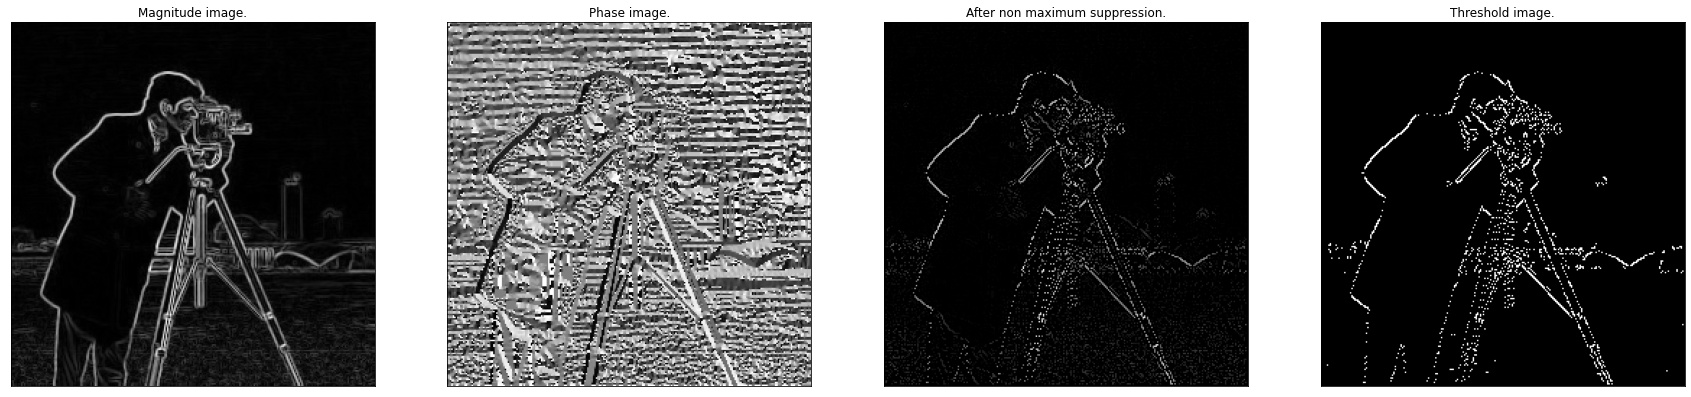

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

Im = cv2.imread('./images/cameraman.jpg', cv2.IMREAD_GRAYSCALE)

t_low = 100
t_high = 250
I_edges = my_cannyAlgorithm(Im, t_low, t_high)

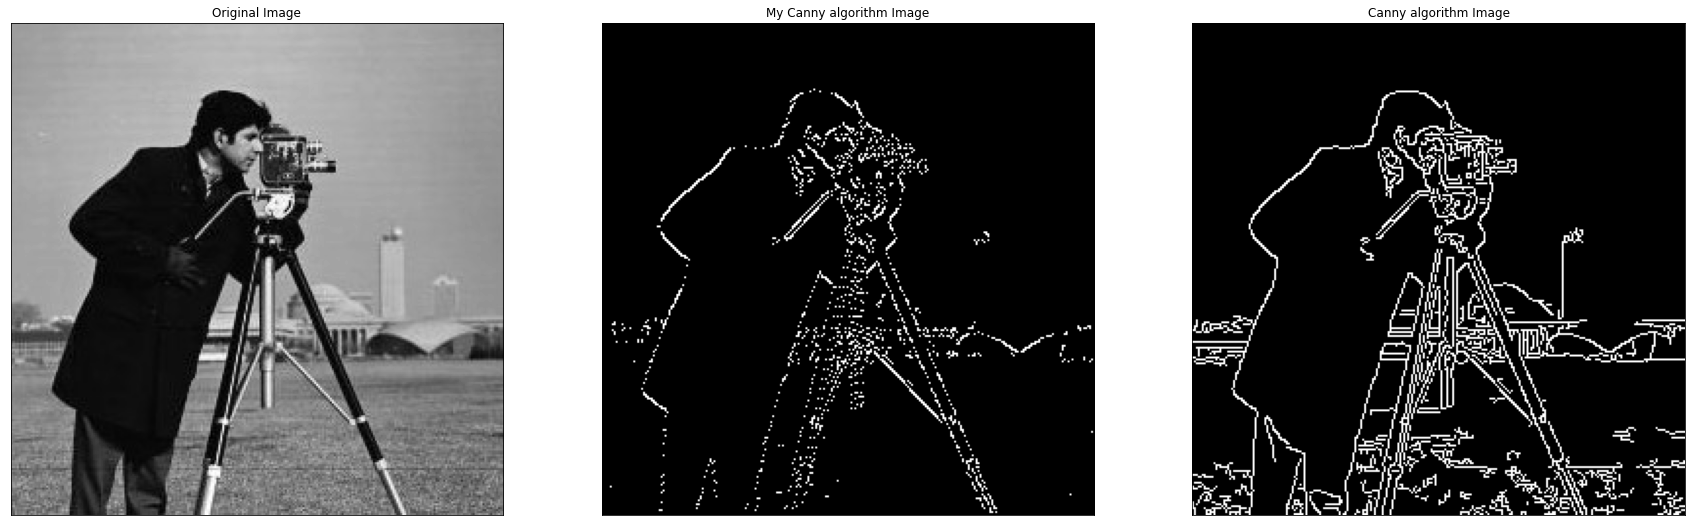

In [6]:
# LOCKED cell: useful to check and visualize the results.

plt.figure(figsize=(30,30))
plt.subplot(131), plt.imshow(Im, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(I_edges, cmap='gray')
plt.title('My Canny algorithm Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(cv2.Canny(Im,t_low, t_high, L2gradient=False), cmap='gray')
plt.title('Canny algorithm Image'), plt.xticks([]), plt.yticks([])
plt.show()

# Problem 2

One of the most popular approaches to feature detection is the **Harris corner detector**, after a work of Chris Harris and Mike Stephens from 1988.

**a)** Use the function in opencv `cv2.cornerHarris(...)` ([Documentation](https://docs.opencv.org/master/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345)) with `blockSize=3, ksize=3, k=0.04` with the **./images/chessboard.png** image to detect the corners (you can find the image on CANVAS).

**b)** Plot the image with the detected corners found.

**Hint**: Use the function `cv2.drawMarker(...)` ([Documentation](https://docs.opencv.org/trunk/d6/d6e/group__imgproc__draw.html#ga644c4a170d4799a56b29f864ce984b7e)) to show the corners in the image.

**c)** Detect the corners using the images **./images/arrow_1.jpg**, **./images/arrow_2.jpg** and **./images/arrow_3.jpg**; describe and compare the results in the three images.

**d)** What happen if you change (increase/decrease) the `k` constant for the "corner points"? 


In [7]:
# Section a)

# Read image
Im = cv2.imread('./images/chessboard.png', cv2.IMREAD_GRAYSCALE)

# Detect feature points
featured_im = cv2.cornerHarris(Im, blockSize=3, ksize=3, k=0.04)

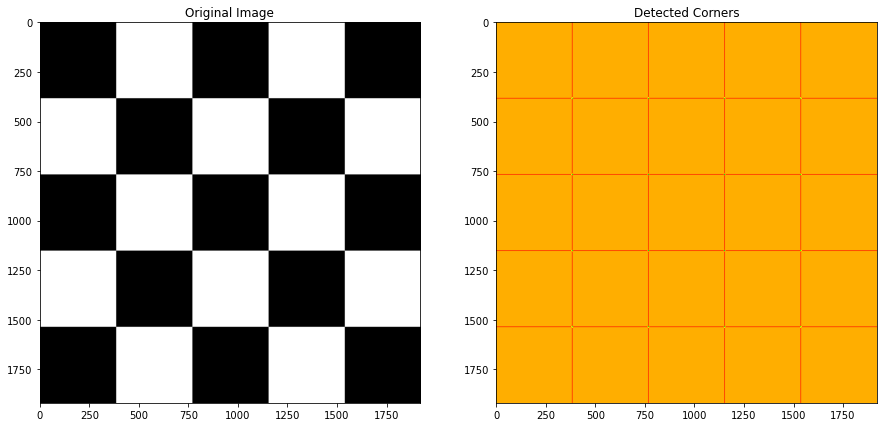

In [8]:
# Section b)
# Plot the results
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(Im, cmap='gray')
plt.subplot(122)
plt.title('Detected Corners')
plt.imshow(featured_im, cmap='gist_rainbow')
plt.show()

*The images are plotted with a different color map so we can notice in an easier way the detected corner points.*

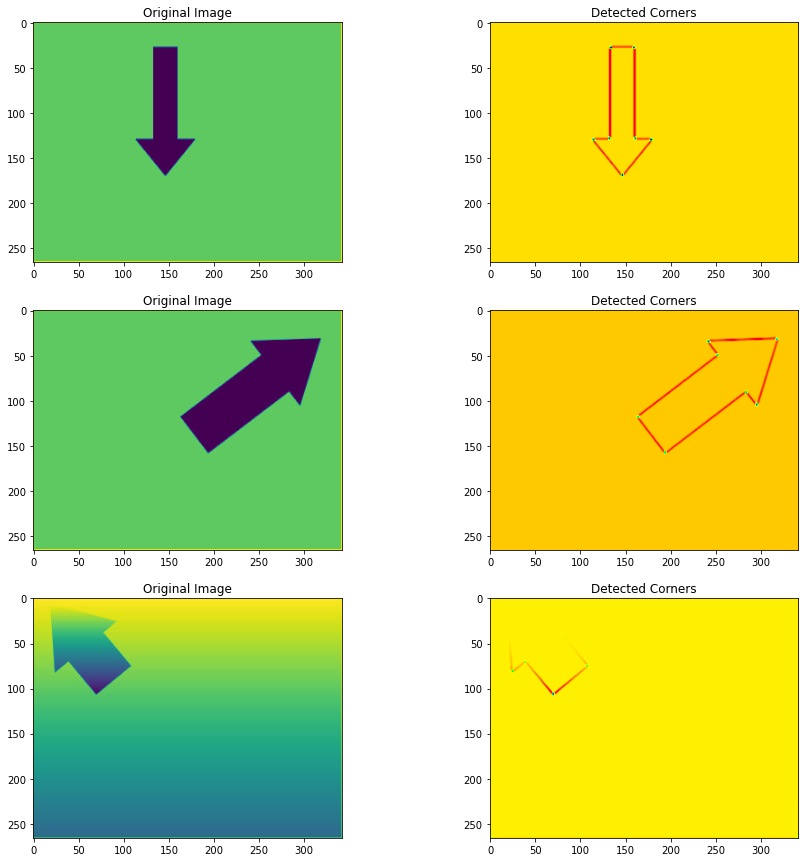

In [9]:
# Section c)
# Read images
Im1 = cv2.imread('./images/arrow_1.jpg', cv2.IMREAD_GRAYSCALE)
Im2 = cv2.imread('./images/arrow_2.jpg', cv2.IMREAD_GRAYSCALE)
Im3 = cv2.imread('./images/arrow_3.jpg', cv2.IMREAD_GRAYSCALE)

# Detect feature points
featured_im1 = cv2.cornerHarris(Im1, blockSize=3, ksize=3, k=0.04)
featured_im2 = cv2.cornerHarris(Im2, blockSize=3, ksize=3, k=0.04)
featured_im3 = cv2.cornerHarris(Im3, blockSize=3, ksize=3, k=0.04)

# Plot the results
plt.figure(figsize=(15,15))

# Arrow_1
plt.subplot(321)
plt.title('Original Image')
plt.imshow(Im1)
plt.subplot(322)
plt.title('Detected Corners')
plt.imshow(featured_im1, cmap='gist_rainbow')

# Arrow_2
plt.subplot(323)
plt.title('Original Image')
plt.imshow(Im2)
plt.subplot(324)
plt.title('Detected Corners')
plt.imshow(featured_im2, cmap='gist_rainbow')

# Arrow_3
plt.subplot(325)
plt.title('Original Image')
plt.imshow(Im3)
plt.subplot(326)
plt.title('Detected Corners')
plt.imshow(featured_im3, cmap='gist_rainbow')

plt.show()

Notice the first two images feature detection is very well perfomed, while in the third image it has problems to detect the feature points in the top left corner, where the arrow starts to fade.

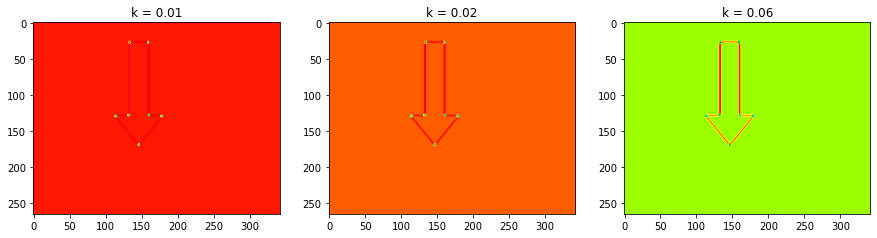

In [10]:
# Section d)
# Detect feature points
featured_im1 = cv2.cornerHarris(Im1, blockSize=3, ksize=3, k=0.01)
featured_im2 = cv2.cornerHarris(Im1, blockSize=3, ksize=3, k=0.02)
featured_im3 = cv2.cornerHarris(Im1, blockSize=3, ksize=3, k=0.06)

# Plot the results
plt.figure(figsize=(15,15))

# Arrow_1
plt.subplot(131)
plt.title('k = 0.01')
plt.imshow(featured_im1, cmap='gist_rainbow')

# Arrow_2
plt.subplot(132)
plt.title('k = 0.02')
plt.imshow(featured_im2, cmap='gist_rainbow')

# Arrow_3
plt.subplot(133)
plt.title('k = 0.06')
plt.imshow(featured_im3, cmap='gist_rainbow')

plt.show()

Checking the results we can appreciate the union between corners points is stronger the more k we introduce. As we see, with k = 0.01 (almost 0) we only notice the corner points, while with k = 0.06 we can see very easily the edges between the corner points.

# Problem 3 

**a)** What is the SIFT approach? Describe the steps involved.

**b)** Why this approach is more popular than the Harris detector?

**c)** Explain the difference between a feature detector and a feature descriptor.

**Section a)**

The Scale Invariant Feature Transform (SIFT) approach is a way of detecting feature points so we avoid problems related with the scale of the image.

**Section b)**

The SIFT approach is more popular than the Harris detector due to his scale invariant property, the Harris detector is rotation and translation invariant but not *scale invariant* this is what makes the SIFT approach better than the Harris detector.

**Section c)**

The feature descriptor not only finds the feature points but also finds the image gradient magnitudes and orientation in the neighbourhood.


### Delivery (dead line) on CANVAS: 17.10.2021 at 23:59


## Contact
### Course teacher
Professor Kjersti Engan, room E-431,
E-mail: kjersti.engan@uis.no

### Teaching assistant
Tomasetti Luca, room E-401
E-mail: luca.tomasetti@uis.no


## References

[1] S. Birchfeld, Image Processing and Analysis. Cengage Learning, 2016.

[2] I. Austvoll, "Machine/robot vision part I," University of Stavanger, 2018. Compendium, CANVAS.